# Supervised learning approach to refugee resettlment

In [515]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
import sklearn
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
import time

# !pip install category_encoders

In [517]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = (
    None  # default='warn', this removes warning on dropping columns
)

warnings.filterwarnings("ignore", category=DeprecationWarning) # Warning for future states of used libraries
warnings.simplefilter(action='ignore', category=FutureWarning) # Warning for future states of used libraries
warnings.simplefilter(action='ignore', category=UserWarning) # Warning for known bug with plotting the barh graphs

## Data Import and Prep
First lets read in the data from our prepared dataset, and do some priliminary work to select subsets of features

In [457]:
# Read in the dataset prepared in Create_Target notebook
rsp_df = pd.read_csv("../Data/processed/dataset_2016-19_target")

In [458]:
# Drop constructed variables
columns_to_drop = [col for col in rsp_df.columns if col.startswith("ui_")]
rsp_df.drop(columns_to_drop, axis=1, inplace=True)

# Drop answers that are binaries for subquestions in the survey. 
# These are asked post resettlment so wont be used in main work of this notebook.
ma = ['qn17_01','qn17_02','qn17_03','qn17_04','qn17_05','qn17_06','qn17_07','qn17_08','qn17_97','qn31f',\
      'qn33f','qn34f','qn26ha_01','qn26ha_02','qn26ha_03','qn26ha_04','qn26ha_05','qn26ha_06','qn26ha_07',\
      'qn26ha_08','qn29a_97','qn29a_02','qn29a_03','qn29a_04','qn29a_05','qn29a_06','qn29a_07','qn29a_08',\
      'qn29a_09','qn29a_10','qn29a_11','qn29a_12','qn29a_97','qn29d_01','qn29d_02','qn29d_03','qn29d_04','qn29d_97']
rsp_df.drop(ma, axis=1, inplace=True)

Using machine learning to predict resettlment success can be divided up into two action types: Proactive & Reactive. The proactive goal would be to understand a refugee's needs at time of resettlment. To understand this we will look at the information known to us at the time of resettlment. The reactive approach would aim to identify populations that might be at need of additional assistance who are already living in the United States. To understand this population, we will look at the data availible to us from after resettling.

In [459]:
# Features known before resettleing
pre_feats = ["numppl", "qn1c", "qn1d", "qn1f", "qn1g", "qn1h", "qn1i", "qn2a", "qn2b", "qn3a", "qn4a", "qn4c", "qn1jyear",\
             "qn1k", 't_resettlement']

# Features of current life
post_feats = ["qn4b", "qn4e", "qn4j", "qn5a", "qn5b", "qn6a", "qn6b", "qn7", "qn8a", "qn9", "qn10a", "qn11a", "qn11aa"\
              , "qn12", "qn13", "qn18b", "qn18dyear", "qn18e", "qn19b", "qn20", "qn24a", "qn24b", "qn25a", "qn25b", "qn25c"\
              , "qn25d", "qn26b", "qn26d", "qn26estate", "qn26f", "qn26h", "qn27a", "qn27bmnth", "qn30a", "qn30d", "qn31a"\
              , "qn31d", "qn31e", "qn32a", "qn32d", "qn32e", "qn33a", "qn33d", "qn33e", "qn34a", "qn34d", "qn34e", "qn35a"\
              , "qn38a", "qn38b", "qn38c"]


## Proactive resettlement analysis

In [460]:
# Select only features identified as avialible at time of resettlment.
pre_df = rsp_df[pre_feats]

# Apply binary/ordinal encoding where needed, and convert relevant columns to numeric.
pre_df['qn1f'].replace(['male','female'], [0,1], inplace=True)
pre_df['qn4c'].replace(['no','yes'], [0,1], inplace=True)
pre_df['qn4a'].replace(['not at all','not well','very well','well'], [0,1,2,3], inplace=True)

pre_df["qn1f"] = pd.to_numeric(pre_df["qn1f"])
pre_df["qn4c"] = pd.to_numeric(pre_df["qn4c"])
pre_df["qn4a"] = pd.to_numeric(pre_df["qn4a"])

# To get our classifiers to work, we can't have NaNs. Since there are only 59 NaNs in the dataset, we drop them.
pre_df.dropna(inplace = True )

In [461]:
pre_df.head()

,numppl,qn1c,qn1d,qn1f,qn1g,qn1h,qn1i,qn2a,qn2b,qn3a,qn4a,qn4c,qn1jyear,qn1k,t_resettlement
0,4.0,now married,27.0,1,iraq,iraq,arab,16.0,secondary (or high school diploma),civil servant (civilian in local or national g...,3.0,0.0,2016.0,northeast,1
1,2.0,never married,34.0,0,ethiopia,ethiopia,darod,8.0,primary,student,3.0,1.0,2016.0,midwest,0
2,5.0,now married,38.0,0,somalia,somalia,darod,8.0,primary,self-employed,1.0,0.0,2016.0,midwest,0
3,5.0,divorced,38.0,1,somalia,somalia,other,0.0,none,self-employed,0.0,0.0,2016.0,west,1
5,2.0,divorced,31.0,1,somalia,somalia,darod,3.0,primary,self-employed,3.0,0.0,2016.0,south,0


<Axes: >

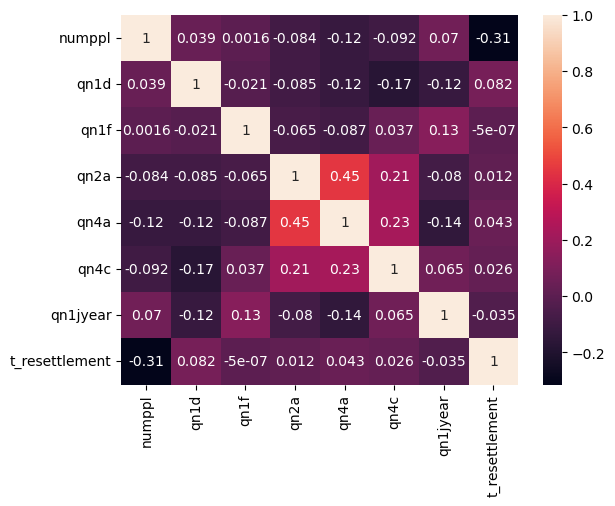

In [462]:
# Lets take a quick look at the correlation between our numeric features and our target.
corr = pre_df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True)

Looking at just these features, there doesn't appear to be any strong correlation between the most of the features and the target variable. The one exception to this is the number of people in the household, which has a negative correlation with a successful resettlment. 

What this correlation matrix doesn't do is give any insight into how the categorical features impact the success of a resettlment, and if there is any overly correlated features between themselves. To understand the overlap between categories, we can calculate the Cramers V value between them all.

In [463]:
def cramers_V(var1,var2):
    """https://github.com/vasukumar92/Immigration-Data---Visual-Analytics.git"""
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return np.sqrt(stat/(obs*mini))

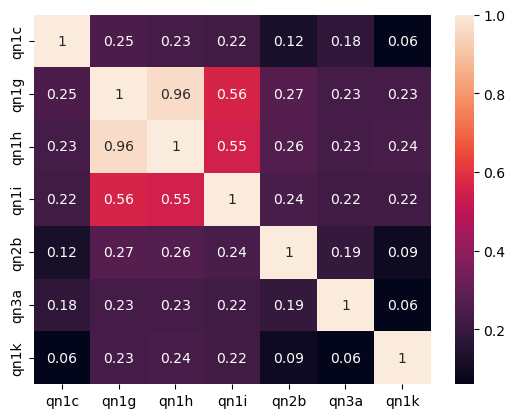

In [464]:
pre_cat_df = pre_df[[col for col in pre_df.columns if pre_df[col].dtype=="O"]]
rows= []

for var1 in pre_cat_df.columns:
    col = []
    for var2 in pre_cat_df.columns:
        cramers =cramers_V(pre_cat_df[var1], pre_cat_df[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
cat_corr = pd.DataFrame(cramers_results, columns = pre_cat_df.columns, index =pre_cat_df.columns)
  
# plotting the heatmap
hm = sns.heatmap(data=cat_corr,
                annot=True)
  
# displaying the plotted heatmap
plt.show()

Betweeen out categorical variables, we can see that there is significant overlap between the country of birth (qn1g) and the country of origin (qn1h). This comes as no surprise given the inherent relation between those features, along with the use of country of birth to imput some data into country of origin during data prepreration. Given the overlap, we will drop the country of birth. 

Finally, we need to encode these categorical features to work with our model. For this step we will be using target encoding. Before the encoding however, we need to first split the dataset up in to training, validation, and testing datasets to avoid data leakage.

In [465]:
pre_df.drop("qn1g", axis=1, inplace=True)

# Train/test/validation split - 70 - 15 - 15
y = pre_df["t_resettlement"]
X = pre_df.drop("t_resettlement", axis=1)

# 1st split (Getting test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2nd split (Getting validation set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(15 / 85), random_state=42
)

In [466]:
# Given the high cardinality of our categorical features, we opt to use a target encoder. 
# A good explaination of this technique can be found here: https://maxhalford.github.io/blog/target-encoding/
encoder = ce.TargetEncoder(return_df=True)
X_train_te = encoder.fit_transform(X_train, y_train)
X_val_te = encoder.transform(X_val)
X_test_te = encoder.transform(X_test)

In [467]:
# In order to for our classifers to work as intended and be comparable to one another, we apply an sklearn.StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_te)
X_val_sc = scaler.transform(X_val_te)
X_test_sc = scaler.transform(X_test_te)

In [468]:
# Importing the models we want to test
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

# Initializing a list of the differnt model types
models = []
models += [['Dummy Classifer', DummyClassifier(strategy="uniform")]]
models += [['Naive Bayes', GaussianNB()]]
models += [['SGD', OneVsOneClassifier(SGDClassifier())]]
models += [['Logistic Regression', LogisticRegression()]]
models += [['Support Vector Machine', SVC()]]
models += [['Gradient Boost', GradientBoostingClassifier()]]
models += [['Random Forest', RandomForestClassifier()]]

model_name_abrv = ['DC','NB','SGD','LR','SVM','GB','RF'] # Abbrevriated names of models for plotting

In [469]:
result_ST = []
model_names = []
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True) # Initialize the kfolds for cross validation

# Train models, store and print accuracy scores
for name, model in models:
    loop_start = time.time()
    cv_score = cross_val_score(model, X_train_sc, y_train, cv = kfold, scoring = 'accuracy')
    result_ST.append(cv_score)
    model_names.append(name)
    loop_end = time.time()
    print(name+':', round(cv_score.mean(),3), '('+str(round(cv_score.std(),3))+')',
          'Runtime:', str(round(loop_end - loop_start,2))+'s')
    print()

Dummy Classifer: 0.508 (0.03) Runtime: 0.02s

Naive Bayes: 0.671 (0.04) Runtime: 0.03s

SGD: 0.638 (0.031) Runtime: 0.11s

Logistic Regression: 0.706 (0.038) Runtime: 0.04s

Support Vector Machine: 0.698 (0.031) Runtime: 1.74s

Gradient Boost: 0.692 (0.032) Runtime: 2.27s

Random Forest: 0.683 (0.03) Runtime: 4.12s



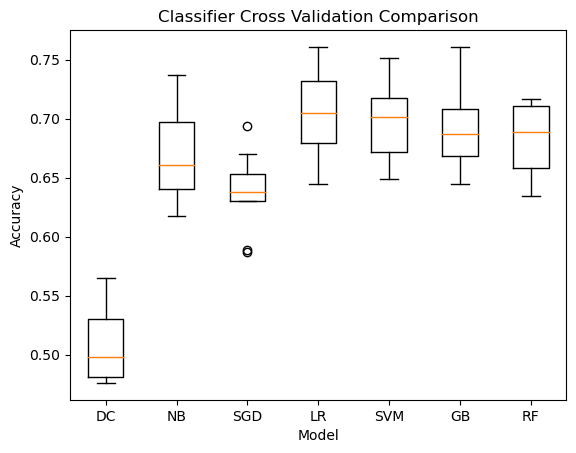

In [470]:
# Let's plot our results to visually see the difference
fig, ax = plt.subplots(1,1)
plt.boxplot(result_ST)
ax.set_xticklabels(model_name_abrv)
ax.set_title('Classifier Cross Validation Comparison')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

### See if we can train a model to efficiently predict resettlment based on features

In [471]:
# To begin our grid search, we initizlize a dictionary with the random forest's parameters as keys, and the
# values we want to test as values.
grid_parameters = {
    'penalty': ['l1', 'l2'],
    'C': [1, 10, 100, 1000],
    'solver'  : ['lbfgs', 'liblinear', 'newton-cg']
}

# This is the chunck that takes the longest. We pass the classifer type, and parameters into the function to grid seach.
# Verbose only impacts what is displayed, setting it to 3 gives us the score of each test.
# In this case, we use cv=5, that means each parameter will get 1 tests. Increasing this extends runtime significantly.
grid = GridSearchCV(LogisticRegression(), grid_parameters, verbose=3, cv=5)
grid.fit(X_train_sc,y_train)

print(grid.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END .......C=1, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END .C=1, penalty=l1, solver=liblinear;, score=0.683 total time=   0.0s
[CV 2/5] END .C=1, penalty=l1, solver=liblinear;, score=0.693 total time=   0.0s
[CV 3/5] END .C=1, penalty=l1, solver=liblinear;, score=0.705 total time=   0.0s
[CV 4/5] END .C=1, penalty=l1, solver=liblinear;, score=0.712 total time=   0.0s
[CV 5/5] END .C=1, penalty=l1, solver=liblinear;, score=0.719 total time=   0.0s
[CV 1/5] END ...C=1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END ...C=1, penalty=l1, solver=newton-

[CV 3/5] END C=1000, penalty=l2, solver=newton-cg;, score=0.703 total time=   0.0s
[CV 4/5] END C=1000, penalty=l2, solver=newton-cg;, score=0.710 total time=   0.0s
[CV 5/5] END C=1000, penalty=l2, solver=newton-cg;, score=0.724 total time=   0.0s
LogisticRegression(C=1, penalty='l1', solver='liblinear')


C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Patrick\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    s

In [474]:
# It's Done! Lets check out what our best parameters were.
print(grid.best_score_)
print(grid.best_params_)

0.7026378896882494
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [475]:
# Great, now lets formalize our final logistic regression and check out the accuracy on the test set
lr = LogisticRegression(C=1, penalty='l1', solver='liblinear')
lr.fit(X_train_sc,y_train)
print("Accuracy: ",lr.score(X_test_sc,y_test))

Accuracy:  0.7165178571428571


An accuracy of 0.72 isn't perfect but is markedly better than the 0.51 we saw with the dummy classifier. With this score, we can confidently state that looking at just the features known at time of resettlment, we can predict which people/families might need some additional help with better than what could be done by random guess.

To further improve the score, we would likly need more data. There is certainly more features we could collect at time of entry, but additionally, a longer time range or more surveys could also be helpful. A sample of just over 2,000 refuguees likly isn't fully representative of the population as a whole, and to check if the sample size is holding back the accuracy, we can run a quick sample size test.

In [512]:
# Initialize our lists that will be plotted
sample_sizes = []
scores = []
st_devs = []

# Run through different sample sizes, starting at ~2,00 and incrementing by 200 up to the full 2,000.
for n in np.linspace(len(X_train_sc)/10, len(X_train_sc), 10).astype(int):

    # Creating the subsamples of our training data
    selected_indexes = np.random.choice(len(X_train_sc), n, False)
    y_sub_train = y_train.iloc[selected_indexes]
    X_sub_train = X_train_sc[selected_indexes]

    # Create a model using the best hyperparameters found during the grid search
    lr_sub = LogisticRegression(C=1, penalty='l1', solver='liblinear')
    cv_score = cross_val_score(lr_sub, X_sub_train, y_sub_train, cv = 5, scoring = 'accuracy')

    # Retrieve our evaluation metrics for this iteration
    cv_mean = cv_score.mean()
    cv_std = cv_score.std()

    # Add our values to our lists to be plotted
    sample_sizes.append(n)
    scores.append(cv_mean)
    st_devs.append(cv_std)

    # Print out the scores to see if accuracy is progressing
    print('Sample size:', n, 'Score:', round(cv_score.mean(),3))

Sample size: 208 Score: 0.639
Sample size: 417 Score: 0.669
Sample size: 625 Score: 0.672
Sample size: 834 Score: 0.685
Sample size: 1042 Score: 0.701
Sample size: 1251 Score: 0.692
Sample size: 1459 Score: 0.693
Sample size: 1668 Score: 0.698
Sample size: 1876 Score: 0.702
Sample size: 2085 Score: 0.706


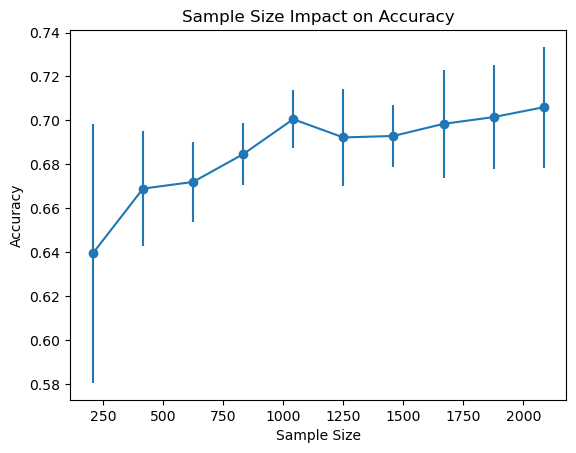

In [513]:
# Using an error bar graph, we can see the progression of accuracy, and the shrinking standard deviation as n increases
plt.errorbar(sample_sizes, scores, st_devs, marker = 'o')
plt.title('Sample Size Impact on Accuracy')
plt.xlabel("Sample Size")
plt.ylabel("Accuracy")
plt.show()

Surprisingly, the accuracy after 1,000 samples appears to level out considerably, and maintains that score throught the rest of the sampling tests. Rerunning the above cell will actually produce a variety of results, pointing to considerable variation. While this variation would likly be reduced by a larger sample, it seems apparent that even with a larger sample, accuracy won't increase significantly.

Just being able to predict individuals who might have a harder time resettling is great in that we could preemptivly create stratigies for these people. The logical next step would be trying to understand why these individuals might have more trouble resettling, and try to formulate ideas of how we can help mitigate these issues.

### Using Logistic Regression to understand resettlment success
Now that we have a model we trust, we can look into what features are important to our prediction, and how important they are.

<Axes: ylabel='Feature'>

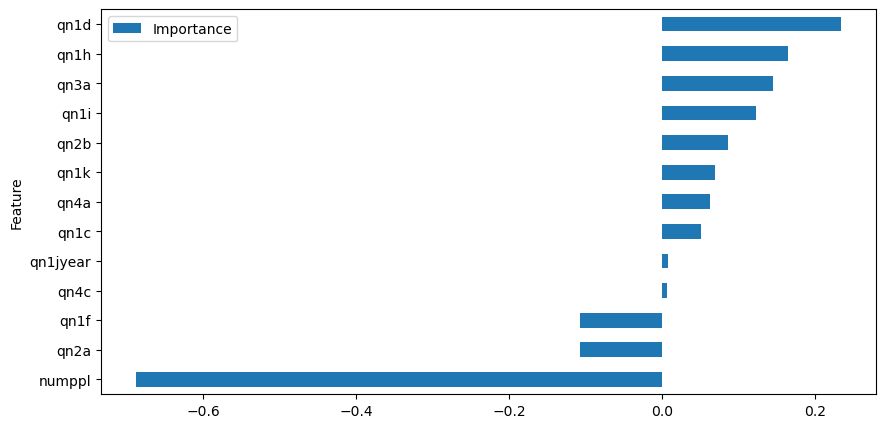

In [473]:
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 5))

From the above chart, we can see that a few features of a refugees life can have a considerable impact on if their resettlment was successful. The biggest factor is the number of people in ones family, followed by their age (qn1d) and country of origin (qn1h). Our model shows that the larger the family at the time of surveying (extrapolated to be heavily related to the family size at time of resettling) has a negative impact on the success, as defined by us, of a resttlement, while the higher the respondents age, the more likly their success is. The age of a respondent will also likly influence the 4th most impactful feature, whether they had a job before resettling, as an older individual will be more likly to have had a job.

The year they came to the US and whether or not they had english instruction prior to resettling (qn4c) had almost no impact. A point of note on qn4c is that it only indicates if there was formal instruction on english, not if the respondent spoke the language.

### Followup Analysis
From the logistic regression model, we saw that country of origin can play an impactful role in resettlment success rate. To better understand this impact, lets look at bit deeper at how the area and ethnicity a refugee comes from plays a role in resettling.

#### How your country of origin impacts resettlment success
Seeing as country of origin is one of the more impactful influencers on our target variable, we wanted to look a bit more into how countries differed. An easy approach to understand these differences is by calculating the mean of our target varibale for each country option.

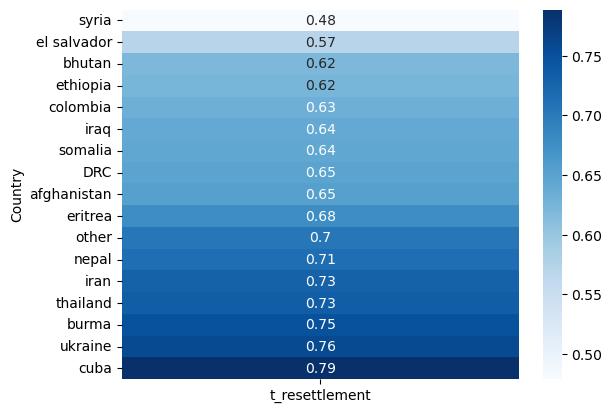

Country,DRC,afghanistan,bhutan,burma,colombia,cuba,el salvador,eritrea,ethiopia,iran,iraq,nepal,other,somalia,syria,thailand,ukraine
count,295.00,26.00,226.00,292.00,19.00,90.00,84.00,31.00,8.00,151.00,897.00,21.00,263.0,205.00,259.00,15.00,99.00
t_resettlement,0.65,0.65,0.62,0.75,0.63,0.79,0.57,0.68,0.62,0.73,0.64,0.71,0.7,0.64,0.48,0.73,0.76


In [353]:
qn1h_df = pre_df[['qn1h', 't_resettlement']].rename(columns={'qn1h':'Country'}).replace(["democratic republic of the congo"], ["DRC"])
qn1h_means = qn1h_df.groupby('Country', as_index=True)\
       .agg({'Country':'size', 't_resettlement':'mean'})\
       .rename(columns={'Country':'count','t_resettlement':'t_resettlement'})

sns.heatmap(qn1h_means.drop(columns=['count']).sort_values(by=['t_resettlement']), annot=True, cmap='Blues')
plt.show()

round(qn1h_means,2).T

Here we can see that countries like Cuba or Ukraine have the higher succes resettling on average, while countries like Syria and El Salvador are typically worse off. Given the small sample size of some of these coutnries, like El Salvador, the varience in means could just be natural and would need further sampling to be conclusive. 

Instead, we can focus on Syria or Butahn which have more representation in our dataset, but still have poorer resettlment scores.

Additionally, we can look at the ethnicity of our respondents. This field proved to be less impactful on the model outcome, but could be used as a compliment to the country of origin.

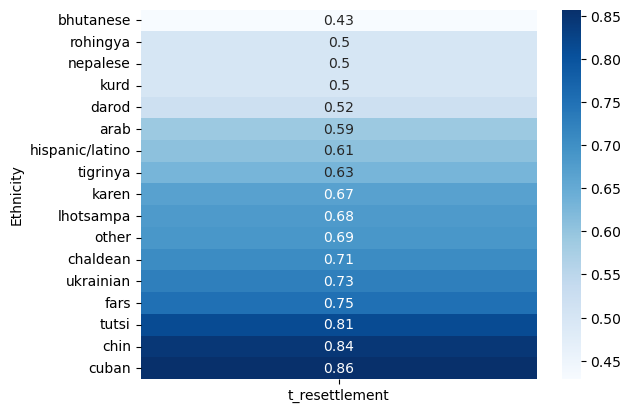

Ethnicity,arab,bhutanese,chaldean,chin,cuban,darod,fars,latino,karen,kurd,lhotsampa,nepalese,other,rohingya,tigrinya,tutsi,ukrainian
count,926.00,21.00,112.00,103.00,35.00,52.00,32.00,150.00,126.00,22.0,75.00,38.0,1154.00,10.0,27.00,32.00,66.00
t_resettlement,0.59,0.43,0.71,0.84,0.86,0.52,0.75,0.61,0.67,0.5,0.68,0.5,0.69,0.5,0.63,0.81,0.73


In [352]:
qn1i_df = pre_df[['qn1i', 't_resettlement']].rename(columns={'qn1i':'Ethnicity'})
qn1i_means = qn1i_df.groupby('Ethnicity', as_index=True)\
       .agg({'Ethnicity':'size', 't_resettlement':'mean'})\
       .rename(columns={'Ethnicity':'count','t_resettlement':'t_resettlement'})

sns.heatmap(qn1i_means.drop(columns=['count']).sort_values(by=['t_resettlement']), annot=True, cmap='Blues')
plt.show()

round(qn1i_means,2).T.rename(columns={'hispanic/latino':'latino'})

Unsurprisingly we see significant overlap with 

Maybe look up percentage of natives in US from some of the top countries (cuba/other/ukrain, el salvador/syria/iraq)

#### Do certain groups of individuals have better luck in differnt regions of the United States?
One of the questions we had when first looking at this data was how much impact the location of resettlement would have on differnt groups of people. We saw in the model itself that location didn't have much impact on on overall resettlment success, but does that hold true if we look at subgroups of our data?

In [357]:
# To start, lets do a similar experiment as we did with country of origin
qn1k_df = pre_df[['qn1k', 't_resettlement']].rename(columns={'qn1k':'Region'})
qn1k_means = qn1k_df.groupby('Region', as_index=True)\
       .agg({'Region':'size', 't_resettlement':'mean'})\
       .rename(columns={'Region':'count','t_resettlement':'t_resettlement'})

# sns.heatmap(qn1k_means.drop(columns=['count']).sort_values(by=['t_resettlement']), annot=True, cmap='Blues')
# plt.show()

qn1k_means.T

Region,midwest,northeast,south,west
count,834.000000,454.000000,767.000000,926.000000
t_resettlement,0.665468,0.640969,0.663625,0.642549


In general, we see that the there is decent spread between the regions, with the exception of the north east being less represented. Between the regions however, there is a similar rate of resettlment success, so now the question is whether or not certain populations of refugess have a higher rate of success in different regions. 

In [450]:
qn1hk_df = pre_df[['qn1k', 'qn1h', 't_resettlement']].rename(columns={'qn1k':'Region','qn1h':'Country'}).replace(["democratic republic of the congo"], ["DRC"])
qn1hk_df = qn1hk_df[~qn1hk_df['Country'].isin(['thailand','nepal','ethiopia','colombia','afghanistan','eritrea'])]
qn1hk_mean = qn1hk_df.groupby(by=['Country','Region'], as_index=True).mean().reset_index()
qn1hk_mean.pivot(index='Country', columns='Region', values='t_resettlement')

Region,midwest,northeast,south,west
Country,,,,
DRC,0.685714,0.660377,0.688172,0.556962
bhutan,0.640449,0.615385,0.567568,0.628571
burma,0.746032,0.517241,0.763158,0.852459
cuba,0.900000,1.000000,0.753623,0.800000
el salvador,0.666667,0.600000,0.487805,0.666667
iran,0.823529,0.875000,0.718750,0.702128
iraq,0.661871,0.607477,0.689266,0.605970
other,0.722222,0.744681,0.755814,0.627660
somalia,0.573171,0.634146,0.685714,0.744681


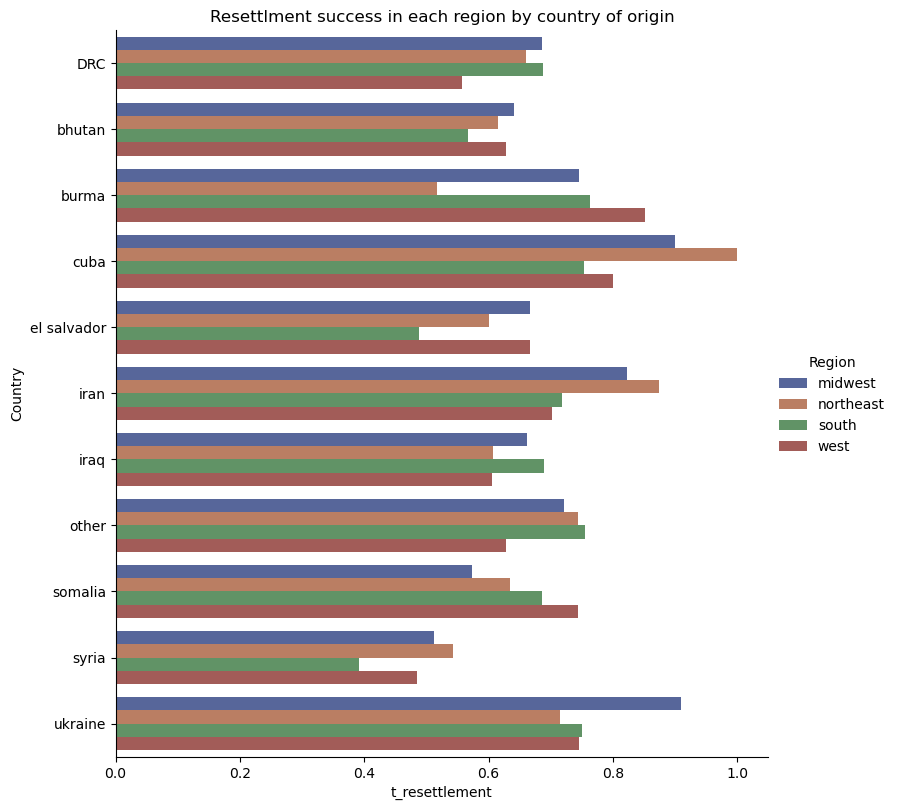

In [518]:
g = sns.catplot(
    data=qn1hk_mean, kind="bar",
    x="t_resettlement", y="Country", hue="Region", palette="dark", alpha=.7, height=8
).set(title='Resettlment success in each region by country of origin'
)

In [453]:
qn1ki_df = pre_df[['qn1k', 'qn1i', 't_resettlement']].rename(columns={'qn1k':'Region','qn1i':'Ethnicity'})
qn1ki_df = qn1ki_df[~qn1ki_df['Ethnicity'].isin(['bhutanese','kurd','ethiopia','colombia','rohingya','tutsi','cuban','fars','nepalese'])]
qn1ki_mean = qn1ki_df.groupby(by=['Ethnicity','Region'], as_index=True).mean().reset_index()
qn1ki_mean.pivot(index='Ethnicity', columns='Region', values='t_resettlement')

Region,midwest,northeast,south,west
Ethnicity,,,,
arab,0.576923,0.582192,0.611354,0.593060
chaldean,0.756757,1.000000,0.000000,0.611111
chin,0.804878,0.400000,0.933333,0.888889
darod,0.444444,0.285714,0.571429,0.818182
hispanic/latino,0.900000,0.647059,0.593023,0.540541
karen,0.688525,0.583333,0.625000,0.764706
lhotsampa,0.702703,0.680000,0.600000,0.666667
other,0.695502,0.729167,0.690236,0.659574
tigrinya,0.571429,0.666667,0.666667,0.600000


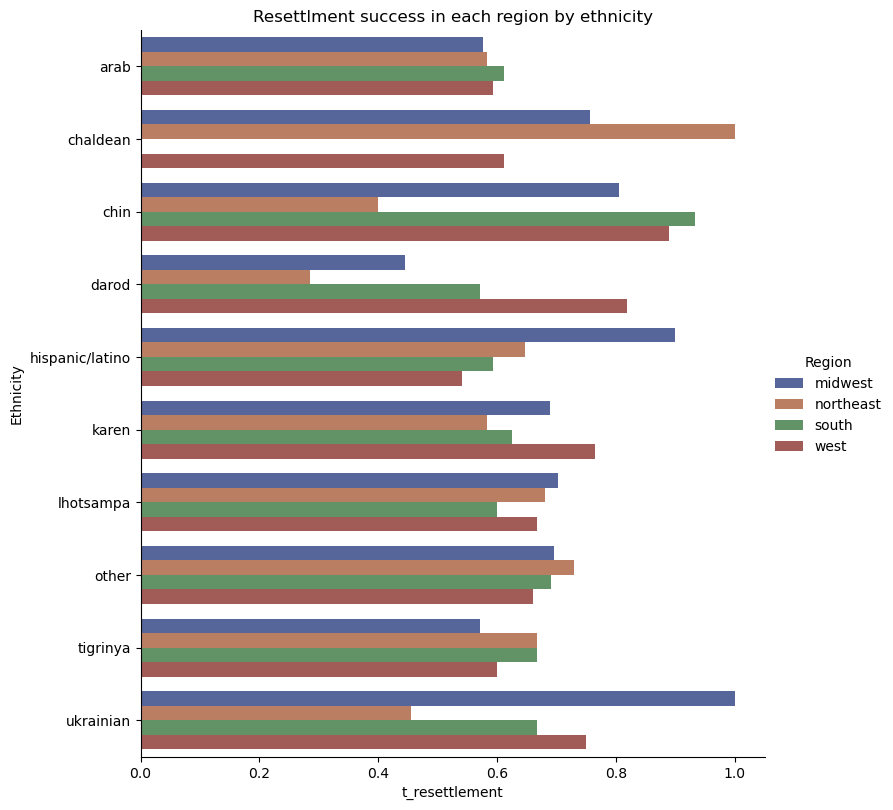

In [519]:
qn1ki_g = sns.catplot(
    data=qn1ki_mean, kind="bar",
    x="t_resettlement", y="Ethnicity", hue="Region", palette="dark", alpha=.7, height=8
).set(title='Resettlment success in each region by ethnicity'
)

Unfortunatly the dataset used in this project doesn't specify what states comprise each region, but in proprietary dataset the survey is broken down into states. This grouping is likly due to using this data at the state level would make the crosstabs by state to small. 

While not knowing what state makes up each region makes a deeper analysis of exisiting communities in each area hard, we can still look at overall trends and try to extract some insights. In the graphic relating country of origin to region, there doesn't appear to be any trends between countries from similar parts of the world, or with similar languages, resettling similarily successfully, or unsuccesfully, between regions. As for ethnicity, the only notable trend is how ethnicities from similar areas with similar histories have more success in seemingly opposite regions. Whether it's the darod and tigrinya people (both from east Africa, though historically have not had good relations), or the ihotsampa and chin refugees.

As mentioned during previous dicussion points, there isn't enough data to draw any solid conclusions. Breaking down the data by country or ethnicity and resettlement regions is stretching a already small dataset very thin. A mor impactful takeway from this section might be that there is potential to investigate this further with more data, along with comparing these results with current data about these populations within the regions of interest.

## Post-Resettlment Feature Analysis

In [64]:
post_feat_fi = ["qn4b", "qn4e", "qn4j", "qn26b", "qn26d", "qn26estate", "qn26f", "qn26h", "qn30a", "qn30d", "qn31a"\
              , "qn31d", "qn31e", "qn32a", "qn32d", "qn32e", "qn33a", "qn33d", "qn33e", "qn34a", "qn34d", "qn34e", "qn35a"\
              , "qn38a", "qn38b", "qn38c"]
post_df = rsp_df[post_feat_fi]

In [65]:
post_df

,qn4b,qn4e,qn4j,qn26b,qn26d,qn26estate,qn26f,qn26h,qn30a,qn30d,qn31a,qn31d,qn31e,qn32a,qn32d,qn32e,qn33a,qn33d,qn33e,qn34a,qn34d,qn34e,qn35a,qn38a,qn38b,qn38c
0,well,no,no,16.0,yes,northeast,NaN,yes,yes,12.0,no,0.0,no,no,0.0,no,no,0.0,no,no,0.0,no,no,rented for cash rent,825.0,no
1,well,no,no,13.0,yes,midwest,did not move to another state/it's the first s...,not applicable,no,0.0,no,0.0,no,no,0.0,no,no,0.0,no,NaN,0.0,no,no,rented for cash rent,589.0,yes
2,not well,yes,yes,12.0,yes,midwest,did not move to another state/it's the first s...,yes,yes,12.0,no,0.0,no,no,0.0,no,no,0.0,no,NaN,0.0,no,no,rented for cash rent,970.0,yes
3,well,no,no,17.0,yes,west,better public assistance,no,yes,12.0,NaN,0.0,no,no,0.0,no,no,0.0,no,no,0.0,no,no,rented for cash rent,1070.0,yes
4,not well,no,no,5.0,no,west,better public assistance,yes,yes,12.0,no,0.0,no,NaN,0.0,no,yes,12.0,yes,NaN,0.0,no,no,rented for cash rent,900.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277,well,no,no,72.0,yes,north east,did not move to another state/it's the first s...,yes,no,0.0,no,0.0,no,no,0.0,no,no,0.0,no,no,0.0,no,no,owned by you or someone in this household with...,1600.0,no
3278,not well,no,no,12.0,yes,south,better public assistance,yes,yes,12.0,no,0.0,no,no,0.0,no,no,0.0,no,no,0.0,no,no,rented for cash rent,NaN,no
3279,well,no,no,7.0,yes,south,employment opportunities,yes,yes,12.0,no,0.0,no,no,0.0,no,yes,12.0,yes,no,0.0,no,no,owned by you or someone in this household with...,810.0,yes
3280,not at all,no,no,3.0,yes,midwest,better public assistance,yes,yes,12.0,no,0.0,no,no,0.0,no,yes,12.0,yes,no,0.0,no,no,rented for cash rent,950.0,yes
